In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

from shell.fleet.network import *
logging.basicConfig(level=logging.INFO)

In [3]:
dataset = "combined"
algo = "modular"

experiment_folder = "combined_data_experiment_results"
experiment_name = "leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True"

use_contrastive = False
num_trains_per_class = 64
seed = 0
num_tasks = 10
parallel = False




In [4]:
def set_color(fleet):
    # Create a mapping from agent id to dataset name
    agent_dataset_mapping = {agent.node_id: agent.dataset.name for agent in fleet.agents}
    dataset_colors = {
        'mnist': '#E41A1C',  # Cherry Red
        'kmnist': '#377EB8',  # Sapphire Blue
        'fashionmnist': '#4DAF4A',  # Apple Green
    }

    # Now, add the dataset name as an attribute to each node in the graph
    for node in fleet.graph.nodes:
        # Assuming node corresponds to agent.id
        if node in agent_dataset_mapping:
            dataset_name = agent_dataset_mapping[node]
            fleet.graph.nodes[node]['dataset'] = dataset_colors.get(dataset_name, 'grey')  # Default color


In [48]:
def get_communication(fleet, multiplier=2):
    N = len(fleet.agents)

    # Initialize matrices for summing task_sim values and counting occurrences
    communication_sum = np.zeros((N, N))
    communication_count = np.zeros((N, N))

    for i, agent in enumerate(fleet.agents):
        df = agent.modmod_record.df
        for _, row in df.iterrows():
            j = int(row['neighbor_id'])
            communication_sum[i, j] += row['task_sim']
            communication_count[i, j] += 1

    # Calculate the average only where there's at least one occurrence
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore division by zero
        communication_avg = np.divide(communication_sum, communication_count, out=np.zeros_like(communication_sum), where=communication_count!=0)

    # Apply exponential function to non-zero averages
    communication_avg[communication_avg != 0] = np.exp(communication_avg[communication_avg != 0] * multiplier)


    return communication_avg

In [6]:
def set_weight(fleet, communication):
    G = fleet.graph
    for i, (u, v, d) in enumerate(G.edges(data=True)):
            # Assuming u, v are indices in the communication matrix
            if u < len(communication) and v < len(communication):
                d['weight'] = communication[u, v]
            else:
                d['weight'] = 1  # Default width
            
    edge_widths = [d['weight'] for _, _, d in G.edges(data=True)]
    return edge_widths

In [7]:
def compute_cluster_communications(fleet, communication):
    # Retrieve node colors (cluster identifications)
    node_colors = {node: data['dataset'] for node, data in fleet.graph.nodes(data=True)}
    
    # Initialize variables to store total communications and counts
    in_cluster_total = 0.0
    out_cluster_total = 0.0
    in_cluster_count = 0
    out_cluster_count = 0
    
    N = len(fleet.agents)
    for i in range(N):
        for j in range(N):
            if i == j:
                continue  # Skip self-communications
            # Check if both nodes exist and have a color assigned
            if i in node_colors and j in node_colors:
                if node_colors[i] == node_colors[j]:  # In-cluster
                    in_cluster_total += communication[i, j]
                    in_cluster_count += 1
                else:  # Out-cluster
                    out_cluster_total += communication[i, j]
                    out_cluster_count += 1
    
    # Compute average communications, handling division by zero
    in_cluster_avg = in_cluster_total / in_cluster_count if in_cluster_count else 0
    out_cluster_avg = out_cluster_total / out_cluster_count if out_cluster_count else 0
    
    return in_cluster_avg, out_cluster_avg


In [41]:
save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)

fleet = setup_fleet(save_dir, task_id=9, parallel=False, modify_cfg=None)
fleet.change_save_dir('combined_dataset_engineering_experiment_results')
set_color(fleet)
communication = get_communication(fleet)
edge_widths = set_weight(fleet, communication)



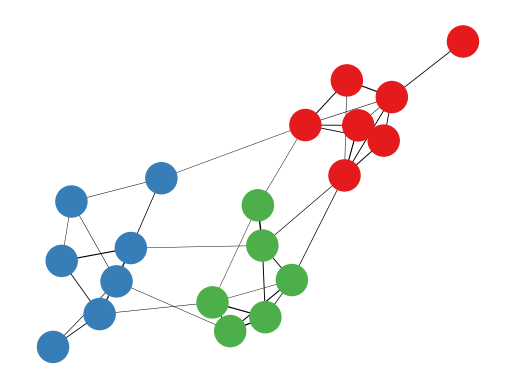

In [43]:
TopologyGenerator.plot_graph(fleet.graph, node_color_attr='dataset',
                            edge_widths=edge_widths, edge_color='black')

In [51]:
seeds = range(8)
in_clus_ls, out_clus_ls = [], []
for seed in seeds:
    save_dir = get_save_dir(experiment_folder, experiment_name,
                            dataset, algo, num_trains_per_class, use_contrastive, seed)


    fleet = setup_fleet(save_dir, parallel=False, modify_cfg=None)
    fleet.load_records()
    fleet.change_save_dir('combined_dataset_engineering_experiment_results')
    set_color(fleet)
    communication = get_communication(fleet,multiplier=1)
    in_clus, out_clus = compute_cluster_communications(fleet, communication)
    in_clus_ls.append(in_clus)
    out_clus_ls.append(out_clus)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (1872, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (1992, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (1940, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (1992, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (1954, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (2115, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'combined', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True, 'ranker': 'instance', 'module_select': 'trust_sim', 'num_shared_module': 1}, 'seed': 0, 'algo': 'modular', 'job_name': 'combined_modular_numtrain_64', 'num_agents': 20, 'root_save_dir': 'combined_data_experiment_results/leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_rando

INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (1901, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (1940, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (1989, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28) (100, 1, 28, 28) (1990, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 9 :(128

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 69420000
Setting seed 0
Setting seed 1000
Setting seed 2000
Setting seed 3000
Setting seed 4000
Setting seed 5000
Setting seed 6000
Setting seed 7000
Setting seed 8000
Setting seed 9000
Setting seed 10000
Setting seed 11000
Setting seed 12000
Setting seed 13000
Setting seed 14000
Setting seed 15000
Setting seed 16000
Setting seed 17000
Setting seed 18000
Setting seed 19000
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'combined', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name

INFO:root:Class sequence: [6 4 1 4 5 6 6 2 2 7 9 7 1 6 4 9 8 5 4 1]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (1940, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2117, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (1850, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (1990, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (2060, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (2037, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (2093, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (1991, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (1866, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28) (100, 1, 28, 28) (2117, 1, 28, 28)
INFO:root:Class sequence: [6 5 5 7 5 1 3 7 0 2 4 8 7 3 3 7 4 5 2 0]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 2 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 69420001
Setting seed 1
Setting seed 1001
Setting seed 2001
Setting seed 3001
Setting seed 4001
Setting seed 5001
Setting seed 6001
Setting seed 7001
Setting seed 8001
Setting seed 9001
Setting seed 10001
Setting seed 11001
Setting seed 12001
Setting seed 13001
Setting seed 14001
Setting seed 15001
Setting seed 16001
Setting seed 17001
Setting seed 18001
Setting seed 19001
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'combined', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name

INFO:root:Class sequence: [3 9 5 0 5 1 8 6 4 5 5 3 0 9 7 6 6 3 6 3]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2019, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (1872, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (2027, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (1932, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (1874, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (1902, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (1989, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (1986, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (1968, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28) (100, 1, 28, 28) (1968, 1, 28, 28)
INFO:root:Class sequence: [0 5 3 0 7 9 4 6 7 6 3 0 7 3 5 4 4 1 3 9]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 2 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 69420002
Setting seed 2
Setting seed 1002
Setting seed 2002
Setting seed 3002
Setting seed 4002
Setting seed 5002
Setting seed 6002
Setting seed 7002
Setting seed 8002
Setting seed 9002
Setting seed 10002
Setting seed 11002
Setting seed 12002
Setting seed 13002
Setting seed 14002
Setting seed 15002
Setting seed 16002
Setting seed 17002
Setting seed 18002
Setting seed 19002
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'combined', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name

INFO:root:Class sequence: [9 2 0 7 0 6 4 3 9 5 4 9 8 0 3 0 7 6 6 1]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2041, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2008, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (1938, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (1992, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (1901, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (1991, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (1954, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (1990, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (1986, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28) (100, 1, 28, 28) (2093, 1, 28, 28)
INFO:root:Class sequence: [5 4 3 0 1 2 9 3 6 0 3 6 9 7 3 6 0 9 4 1]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 2 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 69420003
Setting seed 3
Setting seed 1003
Setting seed 2003
Setting seed 3003
Setting seed 4003
Setting seed 5003
Setting seed 6003
Setting seed 7003
Setting seed 8003
Setting seed 9003
Setting seed 10003
Setting seed 11003
Setting seed 12003
Setting seed 13003
Setting seed 14003
Setting seed 15003
Setting seed 16003
Setting seed 17003
Setting seed 18003
Setting seed 19003
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'combined', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name

INFO:root:Class sequence: [2 6 0 5 4 2 4 8 7 6 1 5 3 8 7 0 4 9 4 0]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (1990, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (1872, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (2014, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (1956, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (1986, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (2027, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (1984, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (2008, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (1991, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28) (100, 1, 28, 28) (1962, 1, 28, 28)
INFO:root:Class sequence: [3 0 9 7 4 1 5 7 5 4 3 1 3 4 9 0 0 5 3 7]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 2 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 69420004
Setting seed 4
Setting seed 1004
Setting seed 2004
Setting seed 3004
Setting seed 4004
Setting seed 5004
Setting seed 6004
Setting seed 7004
Setting seed 8004
Setting seed 9004
Setting seed 10004
Setting seed 11004
Setting seed 12004
Setting seed 13004
Setting seed 14004
Setting seed 15004
Setting seed 16004
Setting seed 17004
Setting seed 18004
Setting seed 19004
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'combined', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name

INFO:root:Class sequence: [1 8 2 9 1 3 7 6 5 0 6 9 6 9 0 2 5 6 6 5]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2109, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2041, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (2145, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (1986, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (1872, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (1967, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (1967, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (2012, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (1850, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28) (100, 1, 28, 28) (1850, 1, 28, 28)
INFO:root:Class sequence: [7 3 8 1 3 7 0 8 9 7 1 7 2 4 7 3 3 1 0 9]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 2 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 69420005
Setting seed 5
Setting seed 1005
Setting seed 2005
Setting seed 3005
Setting seed 4005
Setting seed 5005
Setting seed 6005
Setting seed 7005
Setting seed 8005
Setting seed 9005
Setting seed 10005
Setting seed 11005
Setting seed 12005
Setting seed 13005
Setting seed 14005
Setting seed 15005
Setting seed 16005
Setting seed 17005
Setting seed 18005
Setting seed 19005
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'combined', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name

INFO:root:Class sequence: [2 3 4 8 8 7 6 9 2 9 1 8 8 7 8 7 4 7 0 2]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2042, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (1956, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (2002, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (1967, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (2041, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (2109, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (2002, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (2002, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (2010, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28) (100, 1, 28, 28) (2012, 1, 28, 28)
INFO:root:Class sequence: [9 4 5 4 5 3 1 3 5 8 3 1 0 7 4 0 3 1 7 6]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 2 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 69420006


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/vlongle/miniconda3/envs/shell/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/vlongle/miniconda3/envs/shell/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/vlongle/miniconda3/envs/shell/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vlongle/miniconda3/envs/shell/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/vlongle/miniconda3/envs/shell/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vlongle/miniconda3/envs/shell/lib/python3.10/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueE

Setting seed 6
Setting seed 1006
Setting seed 2006
Setting seed 3006
Setting seed 4006
Setting seed 5006
Setting seed 6006
Setting seed 7006
Setting seed 8006
Setting seed 9006
Setting seed 10006
Setting seed 11006
Setting seed 12006
Setting seed 13006
Setting seed 14006
Setting seed 15006
Setting seed 16006
Setting seed 17006
Setting seed 18006
Setting seed 19006
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'combined', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_mod

INFO:root:Class sequence: [9 5 2 9 1 2 0 1 7 2 3 6 1 3 6 4 3 5 9 2]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (1901, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2041, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (2167, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (2115, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (2060, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (1968, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (2145, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (1940, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (1902, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28) (100, 1, 28, 28) (2041, 1, 28, 28)
INFO:root:Class sequence: [3 9 9 5 7 2 9 6 0 7 4 5 2 1 3 9 9 4 6 5]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 2 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 69420007
Setting seed 7
Setting seed 1007
Setting seed 2007
Setting seed 3007
Setting seed 4007
Setting seed 5007
Setting seed 6007
Setting seed 7007
Setting seed 8007
Setting seed 9007
Setting seed 10007
Setting seed 11007
Setting seed 12007
Setting seed 13007
Setting seed 14007
Setting seed 15007
Setting seed 16007
Setting seed 17007
Setting seed 18007
Setting seed 19007


In [53]:
print(in_clus_ls)
print(out_clus_ls)

[0.4130122067898468, 0.4157223326881655, 0.3520114119886026, 0.40307048454773775, 0.38824799511969904, 0.4264857304336973, 0.375236587939526, 0.43559894884280687]
[0.03264449025621611, 0.042049440240362924, 0.03958999269050208, 0.059821790004012075, 0.03675692737643138, 0.04674866450204086, 0.04653630421353802, 0.028605474591134803]


/tmp/ipykernel_556590/1803205491.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


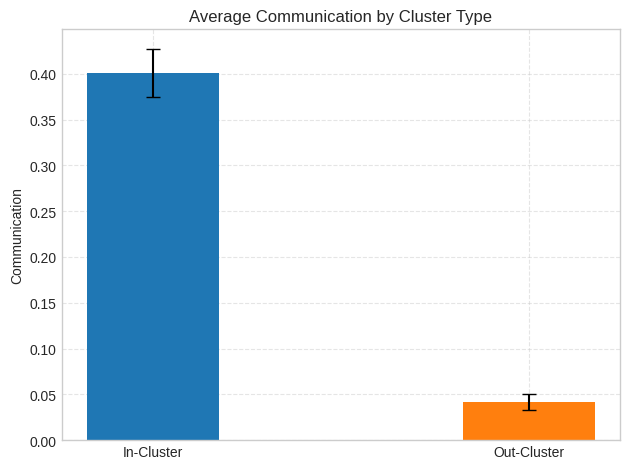

In [63]:
plt.style.use('seaborn-whitegrid')
# Calculate means and standard deviations
in_clus_mean = np.mean(in_clus_ls)
out_clus_mean = np.mean(out_clus_ls)
in_clus_std = np.std(in_clus_ls)
out_clus_std = np.std(out_clus_ls)

# Plotting
labels = ['In-Cluster', 'Out-Cluster']
means = [in_clus_mean, out_clus_mean]
stds = [in_clus_std, out_clus_std]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, means, width, yerr=stds, label='Mean Communication', capsize=5,
                color=['#1f77b4', '#ff7f0e'])
ax.grid(True, which='major', linestyle='--', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Communication')
ax.set_title('Average Communication by Cluster Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
fig.tight_layout()

plt.show()